In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc as pm
import xarray as xr

from pymc import  Model, Normal, sample

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import numpy as np

def w(r_array, args=[5,15,2,1]):
    t = args[0]
    L = args[1]
    T = args[2]
    rho = args[3]
    w_values = np.zeros_like(r_array)  # Initialize an array of the same size as r_array
    
    # Case 1: r <= t / 2
    mask1 = (r_array <= t / 2)
    w_values[mask1] = 4 * (T * r_array[mask1])**2
    
    # Case 2: t / 2 <= r < t
    mask2 = (r_array >= t / 2) & (r_array < t)
    w_values[mask2] = (T * t)**2 + T * (r_array[mask2] - (t / 2))
    
    # Case 3: t < r < L
    mask3 = (r_array >= t) & (r_array < L)
    w_values[mask3] = (T * t)**2 + (T * (t / 2)) + rho * (r_array[mask3] - t)
    
    # Case 4: r >= L
    mask4 = (r_array >= L)
    w_values[mask4] = (T * t)**2 + (T * (t / 2)) + rho * (L - t)
    
    return w_values

# Example usage:
r_array = np.arange(0,20)  # Example input array for r
# t = 5  # Example constant
# L = 15  # Example constant
# T = 2  # Example constant
# rho = 1  # Example constant

w_values = w(r_array)
print("w(r) values:", w_values)


w(r) values: [  0  16  64 101 103 105 106 107 108 109 110 111 112 113 114 115 115 115
 115 115]


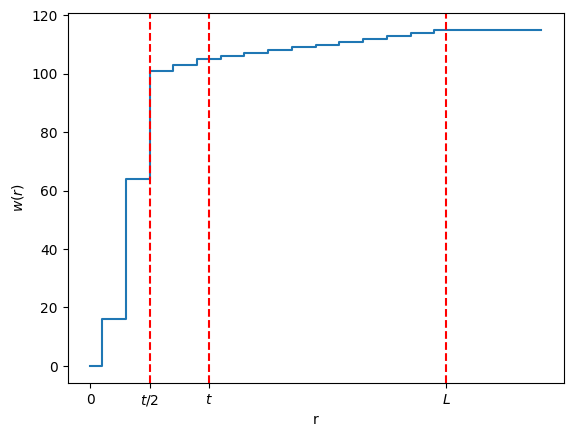

In [3]:
args=[5,15,2,1]
t = args[0]
L = args[1]
T = args[2]
rho = args[3]

plt.plot(w_values,drawstyle="steps-mid")
# Customize the x-axis with specific ticks and labels
plt.xticks([0, t/2, t, L], [r'0', r'$t/2$', r'$t$', r'$L$'])
plt.ylabel(r"$w(r)$")
plt.axvline(x=t/2, color="r", linestyle= "--", label=r"$t/2$")
plt.axvline(x=t, color="r", linestyle= "--", label=r"$t$")
plt.axvline(x=L, color="r", linestyle= "--", label=r"$L$")
plt.xlabel("r")
plt.show()

In [4]:
def G(theta, args):
    theta_norm = np.linalg.norm(theta)
    w_theta = w(theta_norm,args)
    G_theta = np.sqrt(w_theta)

    return G_theta 

In [5]:
N = 100
theta_0 = [0]*N
sigma = 1
t = 5  # Example constant
L = 15  # Example constant
T = 2  # Example constant
rho = 1  # Example constant
y = G(theta_0, args) + np.random.randn(N) * sigma


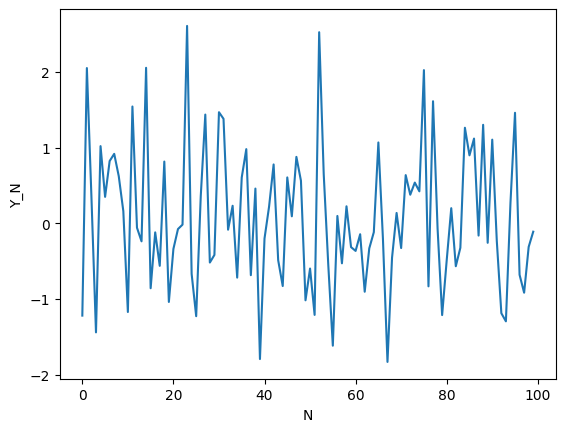

In [6]:
plt.plot(y)
plt.ylabel("Y_N")
plt.xlabel("N")
plt.show()


In [7]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    theta = Normal("theta", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=G(theta_0,args), sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


/Users/doubleluckybear/Desktop/free_energy_barriers/pymc/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

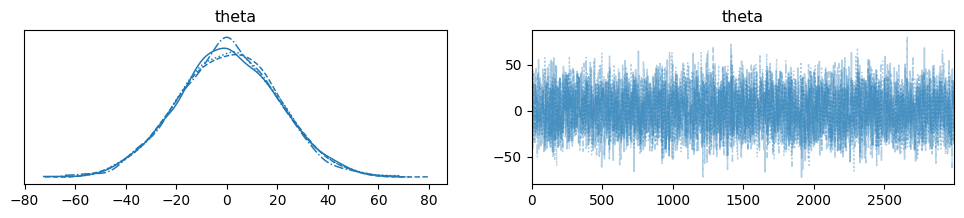

In [8]:
az.plot_trace(idata)

In [9]:
# Get posterior means (or other summary stats)
posterior_means = pm.summary(idata)
print(posterior_means)


        mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.453  19.908 -37.862   36.797      0.286    0.202    4855.0    8410.0   

       r_hat  
theta    1.0  


In [12]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    theta = Normal("theta", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=G(theta_0,args), sigma=sigma, observed=y)

    # Inference!
    initvals = {'theta': 1}
    # draw 3000 posterior samples using NUTS sampling
    trace = pm.sample(3000, initvals=initvals, tune=0, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


/Users/doubleluckybear/Desktop/free_energy_barriers/pymc/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [11]:
az.plot_trace(trace)

ValueError: Can only convert xarray dataarray, xarray dataset, dict, pytree, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not MultiTrace